In [1]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
from rasterio.crs import CRS
import gstools as gs

pd.set_option('display.max_columns', None)

/home/arvinder/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def get_dataframe(data_path, latlon_path):
    # Initialize an empty dictionary to store dataframes and a list for site names
    data_dict = {}
    start_date = '1980-01-01'
    end_date = '2023-12-31'
    common_index = pd.date_range(start=start_date, end=end_date)
    site_name = []

    # Iterate through each gauge directory in data_path
    for gauge in data_path:
        # Iterate through each file in the current gauge directory
        for file_name in os.listdir(gauge):
            # Append the file name to site_name list
            site_name.append(file_name)
            file = os.path.join(gauge, file_name)
            
            # Read the Excel file into a dataframe
            df = pd.read_excel(file)
            
            # Check if the dataframe contains a "Date" column
            if "Date" in df.columns:
                # Convert "Date" column to datetime and set it as the index
                df["Date"] = pd.to_datetime(df["Date"])
                df.set_index("Date", inplace=True)
                
                # Read latitude and longitude data from latlon_path
                lat_lon_df = pd.read_excel(latlon_path)
                lat_lon_df.set_index("site_number", inplace=True)
                
                # Extract site number from the file name
                site_number = int(file_name.split("_")[0])
                
                # Get latitude and longitude for the current site number
                lat_lon = lat_lon_df.loc[site_number]
                latitude = float(lat_lon["Lat"])
                longitude = float(lat_lon["Long_"])
                lat_lon_tup = (latitude, longitude)
                
                # Reindex the dataframe to match the common date range
                df = df.reindex(common_index)
                df.reset_index(inplace=True)
                
                # Add the dataframe to the dictionary with the lat/lon tuple as the key
                data_dict[lat_lon_tup] = df
            else:
                # Rename columns if the dataframe does not have a "Date" column
                df.rename(columns={'DATE': 'Date', 'PRCP': 'Daily Rain (inches)', 'PRCP (in)': 'Daily Rain (inches)'}, inplace=True)
                
                # Convert "Date" column to datetime and set it as the index
                df["Date"] = pd.to_datetime(df["Date"])
                df.set_index("Date", inplace=True)
                
                # Extract latitude and longitude from the first row
                lat_lon = df.iloc[0]
                latitude = float(lat_lon["LATITUDE"])
                longitude = float(lat_lon["LONGITUDE"])
                
                # Drop unnecessary columns
                columns_to_delete = df.columns[:5]
                df.drop(columns=columns_to_delete, inplace=True)
                lat_lon_tup = (latitude, longitude)
                
                # Reindex the dataframe to match the common date range
                df = df.reindex(common_index)
                df.reset_index(inplace=True)
                
                # Add the dataframe to the dictionary with the lat/lon tuple as the key
                data_dict[lat_lon_tup] = df
    
    # Return the dictionary of dataframes and the list of site names
    return data_dict, site_name


In [3]:
prcp_path_hydromet = "/home/arvinder/interpolation/Precipitation/Hydromet"
hydromet_latlon_path = "/home/arvinder/interpolation/Precipitation/Hydromet Gage LatLong.xls"

prcp_path_NOAA = "/home/arvinder/interpolation/Precipitation/NOAA"
NOAA_latlon_path = "/home/arvinder/interpolation/Precipitation/NOAA Gage LatLong.xlsx"
LCRA_shp_pth = "/home/arvinder/interpolation/HUC4_1209/HUC4_1209.shp"

prcp_dict, site_names = get_dataframe([prcp_path_hydromet, prcp_path_NOAA], hydromet_latlon_path)
prcp_coord = list(prcp_dict.keys())

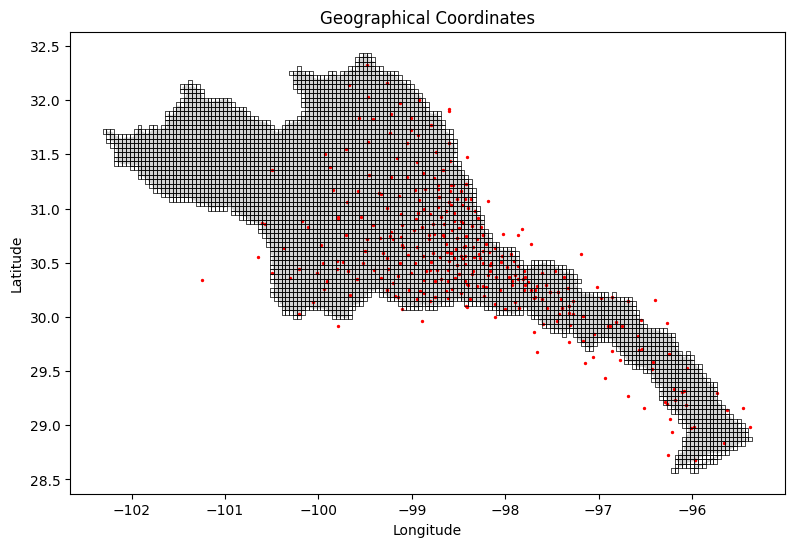

In [4]:
#Read and Reproject the world and grid map to EPSG:3857 (meters)
world = gpd.read_file(LCRA_shp_pth)
world = world.to_crs(epsg=3857)

mesh_grid = gpd.read_file("/home/arvinder/Downloads/prism_4km_mesh/prism_4km_mesh.shp")
mesh_grid = mesh_grid.to_crs(epsg=3857)

# Perform the intersection
intersected_mesh = gpd.sjoin(mesh_grid, world, how='inner', predicate='intersects')

# Reproject the world and grid map to EPSG:4326
intersected_mesh = intersected_mesh.to_crs(epsg=4326)
world = world.to_crs(epsg=4326)

#Plot world, mesh and prcp data
base = world.plot(color='lightgray', figsize=(10, 6))
intersected_mesh.boundary.plot(ax=base, edgecolor='black', linewidth=0.5)

prcp_gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in prcp_coord], crs="EPSG:4326")
prcp_gdf.plot(ax=base, marker='o', color='red', markersize=2)

plt.title('Geographical Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [5]:
# Calculate the centroids using an equal-area projection
equal_area_crs = '+proj=cea'
intersected_mesh['centroid_equal_area'] = intersected_mesh.to_crs(equal_area_crs).centroid.to_crs(intersected_mesh.crs)

# Extract the coordinates of the centroids
centroid_equal_area = intersected_mesh['centroid_equal_area'].apply(lambda point: (point.x, point.y)).tolist()

# Extract x and y coordinates of centroids
centroid_coords = np.array(centroid_equal_area)

# Convert to numpy arrays
coords = np.array(list(prcp_dict.keys()))
values_orig = list(np.array(prcp_data['Daily Rain (inches)']) for prcp_data in prcp_dict.values())
dates = list(list(date_data['index']) for date_data in prcp_dict.values())

# Convert dates to numeric format (days since a reference date)
reference_date = pd.to_datetime("01/01/1980", format="%m/%d/%Y")
numeric_times = []
for date_list in dates:
    numeric_times.append([(date - reference_date).days for date in date_list])


In [6]:
x_coords = np.array(coords[:, 1])   #  Longitude
y_coords = np.array(coords[:, 0])   #  Latitude
i = 0
interpolated_vals = []
interpolated_var = []

# Define the start and end dates 
start_date = np.datetime64('1980-01-01')
end_date = np.datetime64('2023-12-31')

# Create an array of dates between start and end date
dates = np.arange(start_date, end_date, dtype='datetime64[D]')[:150]

while i < len(dates):   #len(dates)

    values = np.array([array[i] for array in values_orig[:]])

    # Define a spatiotemporal variogram model
    model = gs.Exponential(dim=2, var=1.0, len_scale=0.4)

    # Create the kriging field
    krig = gs.krige.Ordinary(
        model, cond_pos=[x_coords, y_coords], cond_val=values
    )

    # Perform the kriging
    field, variance = krig((centroid_coords[:, 0], centroid_coords[:, 1]))
    field[field < 0] = 0
    interpolated_vals.append(field)
    interpolated_var.append(variance)
    i+=1


In [7]:
for i in range(len(interpolated_vals)):
    raster_data = {
    "latitude": centroid_coords[:, 1],
    "longitude": centroid_coords[:, 0],
    "value": interpolated_vals[98]
    }

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(raster_data, geometry=gpd.points_from_xy(raster_data['longitude'], raster_data['latitude']))

    # Define the grid resolution (4km x 4km)
    grid_size = 0.041666666667  # 4km in degrees

    # Define the bounds of the raster
    minx, miny, maxx, maxy = gdf.total_bounds
    width = int(np.ceil((maxx - minx) / grid_size))
    height = int(np.ceil((maxy - miny) / grid_size))

    # Create an empty raster
    raster = np.full((height, width), np.nan, dtype=np.float32)  # Initialize with NaNs to identify empty cells

    # Calculate the transform
    transform = from_origin(minx, maxy, grid_size, grid_size)
    crs = CRS.from_epsg(4326)  # Assuming WGS84

    # Fill the raster with values
    for _, row in gdf.iterrows():
        rowx = int((row.geometry.x - minx) / grid_size)
        rowy = int((maxy - row.geometry.y) / grid_size)
        if 0 <= rowx < width and 0 <= rowy < height:  # Ensure indices are within bounds
            if np.isnan(raster[rowy, rowx]):
                raster[rowy, rowx] = row['value']
            else:
                # Handle multiple points in the same cell; here we take the average
                raster[rowy, rowx] = (raster[rowy, rowx] + row['value']) / 2
        else:
            print("Out of bounds")
        

    # Define the output raster file
    output_file = 'output'+ str(i) + '.tif'

    # Write the raster to a file
    with rasterio.open(
        output_file,
        'w',
        driver='GTiff',
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs=crs,  # WGS84 Latitude/Longitude
        transform=transform,
    ) as dst:
        dst.write(raster, 1)

    break

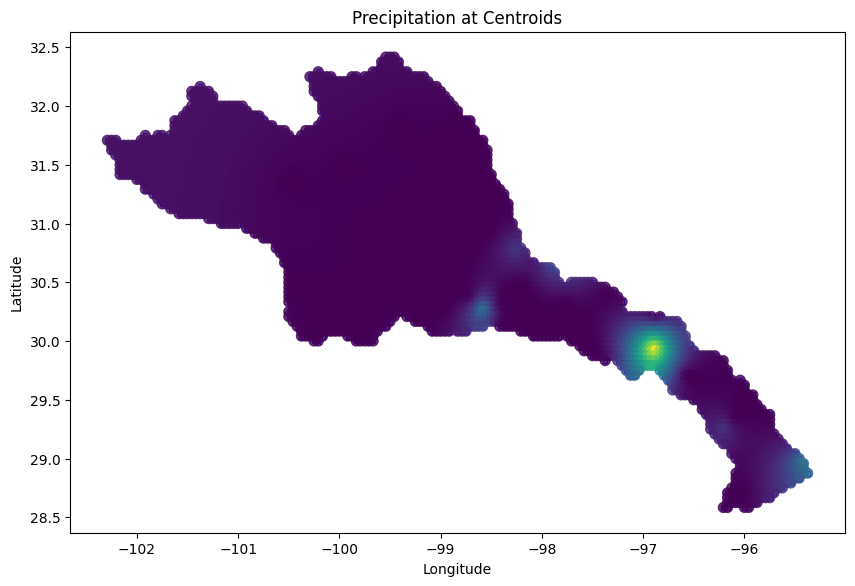

In [8]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
intersected_mesh.plot(ax=ax, facecolor='none', edgecolor='blue')  # Plot the original geometries for reference

day_to_plt = 98  # Which day to plot 

# Plot centroids with color representing precipitation values
ax.scatter(centroid_coords[:, 0], centroid_coords[:, 1], c=interpolated_vals[day_to_plt], cmap='viridis', s=50, alpha=0.8, vmin=0)
plt.title('Precipitation at Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()